<a href="https://colab.research.google.com/github/ShudraRuslan/DSSLab2/blob/main/%D0%A8%D1%83%D0%B4%D1%80%D0%B0%D0%9A%D0%9086_%D0%9B%D0%B0%D0%B12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
import glob 
import cv2
import os
from sklearn.model_selection import train_test_split
from skimage.color import rgb2grey
from keras.utils import to_categorical

Выгрузим необходимые данные из источников в Интернете

In [ ]:
!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip

--2021-03-19 08:41:33--  https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 276294756 (263M) [application/zip]
Saving to: ‘GTSRB_Final_Training_Images.zip’

GTSRB_Final_Trainin 100%[===================>] 263.50M  25.5MB/s    in 12s     

2021-03-19 08:41:46 (21.9 MB/s) - ‘GTSRB_Final_Training_Images.zip’ saved [276294756/276294756]



In [ ]:
!unzip GTSRB_Final_Training_Images.zip

Подготовим данные к работе 

In [ ]:
num_classes= 43
data_path = 'GTSRB/Final_Training/Images'
images = []
image_labels = []
for i in range(num_classes):
    image_path = data_path + '/' + format(i, '05d') + '/'
    for img in glob.glob(image_path + '*.ppm'):
        image = cv2.imread(img)
        image = rgb2grey(image)
        image = (image / 255.0) 
        image = cv2.resize(image, (32, 32)) 
        images.append(image)
       
        labels = np.zeros((num_classes, ), dtype=np.float32)
        labels[i] = 1.0
        image_labels.append(labels)
images = np.stack([img[:, :, np.newaxis] for img in images], axis=0).astype(np.float32)
image_labels = np.matrix(image_labels).astype(np.float32)

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


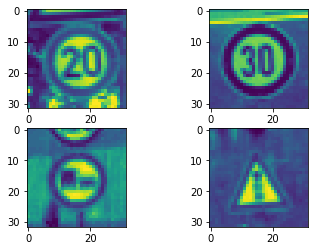

In [ ]:
fig, axes = plt.subplots(2, 2)
axes[0,0].imshow(images[100, :, :, :].reshape(32, 32) )
axes[0,1].imshow(images[1000, :, :, :].reshape(32, 32) )
axes[1,0].imshow(images[16000, :, :, :].reshape(32, 32) )
axes[1,1].imshow(images[30000, :, :, :].reshape(32, 32))
print(image_labels[100, :])
print(image_labels[1000, :])
print(image_labels[16000, :])
print(image_labels[30000, :])

Сделаем разбиение данных на тренировочное и тестовое множество

In [ ]:
train_X, test_X, train_y, test_y = train_test_split(images, image_labels,test_size=0.2)  
                                            

Функция для создания модели и построения графиков зависимости метрик от номера эпохи

In [ ]:
input_shape = (32, 32, 1)
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

def modelBuilder(kernel_initializer=tf.keras.initializers.random_normal, kernel_regularizer=None,
    activation=tf.keras.activations.sigmoid,optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),isBatchNorm=False,isDropOut=False,
    rate=0.2):
  
    model = tf.keras.Sequential(
        [tf.keras.layers.Flatten(input_shape=input_shape)] + \
        ([tf.keras.layers.BatchNormalization(axis=-1)] if isBatchNorm else []) + \
        ([tf.keras.layers.Dropout(rate)] if isDropOut else []) +\
        [tf.keras.layers.Dense(
            units=64, 
            activation=activation,
            kernel_initializer=kernel_initializer,
            kernel_regularizer=kernel_regularizer
        )] + \
        ([tf.keras.layers.BatchNormalization(axis=-1)] if isBatchNorm else []) + \
        ([tf.keras.layers.Dropout(rate)] if isDropOut else []) +\
        [tf.keras.layers.Dense(
            units=64, 
            activation=activation,
            kernel_initializer=kernel_initializer,
            kernel_regularizer=kernel_regularizer
        )] + \
        [tf.keras.layers.Dense(num_classes,activation=tf.keras.activations.softmax)]
    )
    model.compile(
        optimizer=optimizer,
        loss= 'categorical_crossentropy',
        metrics=["accuracy"]
    )
    return model

Определим функцию вывода графиков зависимости функции потерь от эпохи

In [ ]:
def plotMetricsDependency(train_X,train_Y,test_X,test_Y,model, 
                          callback=tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,save_weights_only=True,verbose=0)):
  history=model.fit(train_X,train_Y,epochs=100,batch_size=50,callbacks=callback,
                    validation_data=(test_X, test_Y),verbose=0)
  num_epochs = np.arange(0, len(history.history['accuracy']))
  plt.figure(dpi=200)

  plt.plot(num_epochs, history.history['accuracy'], label='train_acc', c='green')
  plt.plot(num_epochs, history.history['val_loss'], label='val_loss', c='orange')
  plt.plot(num_epochs, history.history['val_accuracy'], label='val_acc', c='blue')
  plt.plot(num_epochs, history.history['loss'], label='train_loss', c='red')
  plt.title('Training Loss and Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Loss/Accuracy')
  plt.legend()

Создадим стандартную модель и проверим ее качество
(kernel_initializer=tf.keras.initializers.random_normal, kernel_regularizer=None,
    activation=tf.keras.activations.sigmoid,optimizer=tf.keras.optimizers.Adam(lr=0.001),isBatchNorm=False,isDropOut=False)

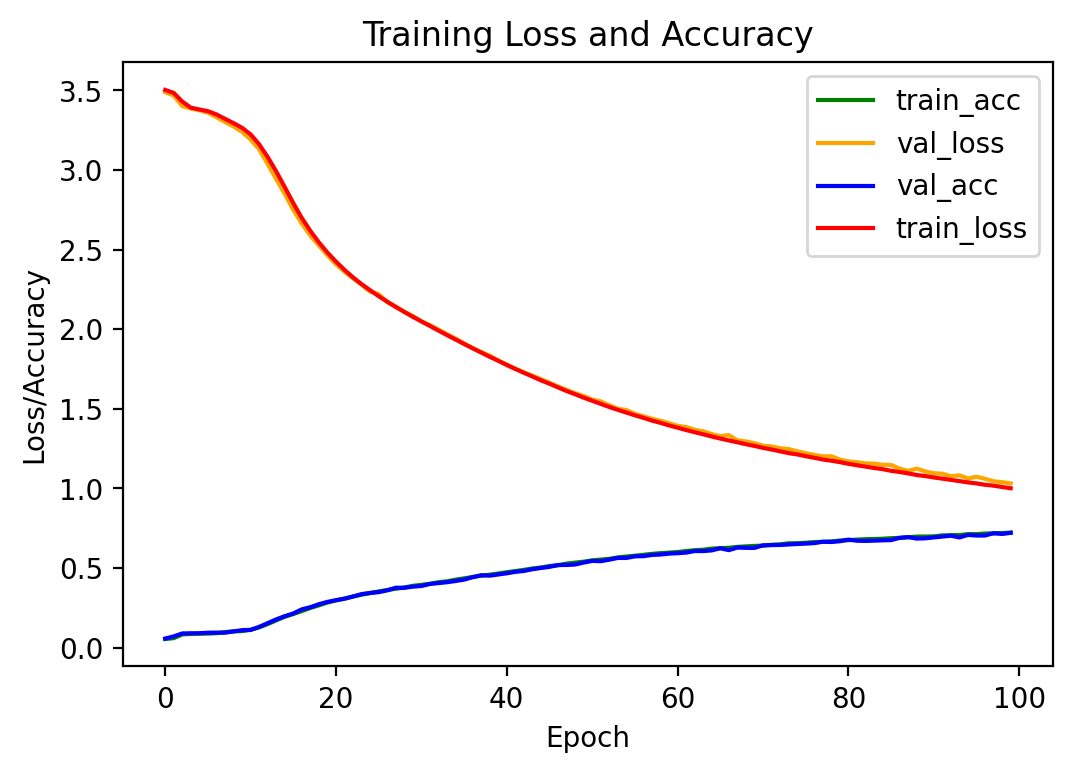

In [ ]:
base_model=modelBuilder()
plotMetricsDependency(train_X,train_y,test_X,test_y,base_model)

Создадим новую модель, используя функцию активации tanh и инициализцию Глоро. Остальные параметры пока оставляем стандартными

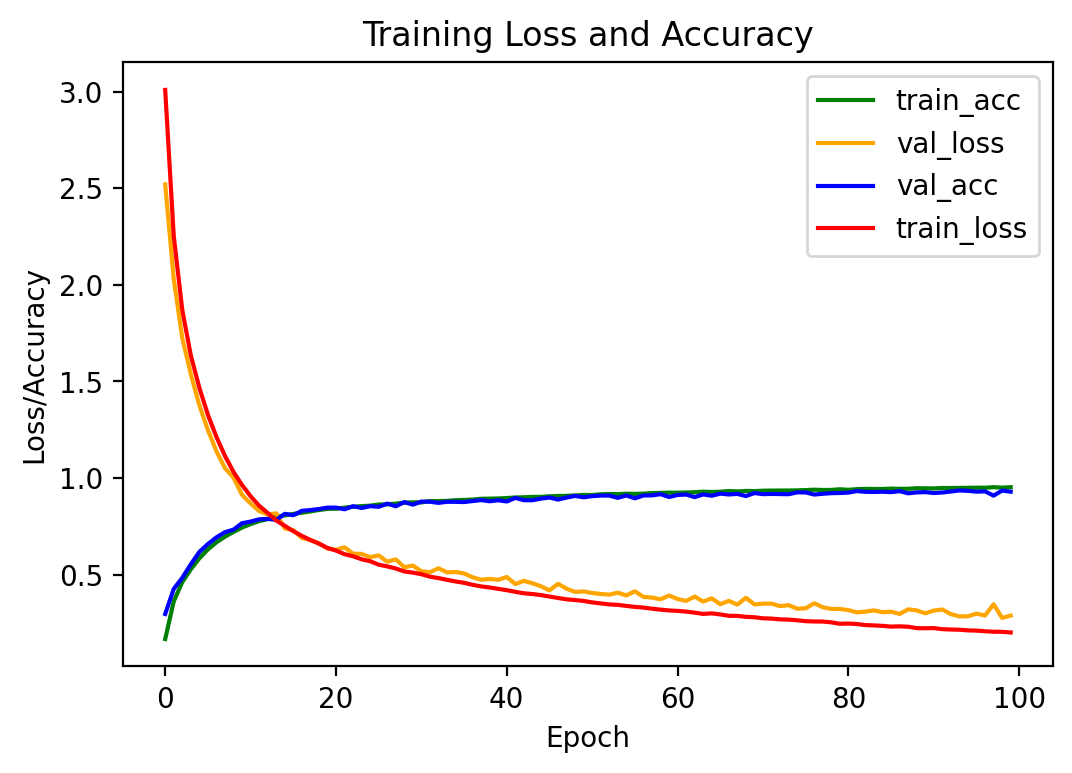

In [ ]:
new_model=modelBuilder(kernel_initializer=tf.keras.initializers.GlorotNormal, activation=tf.keras.activations.tanh)
plotMetricsDependency(train_X,train_y,test_X,test_y,new_model)

Подберем значение скорости обучения. Попробуем увеличть его до 0.1

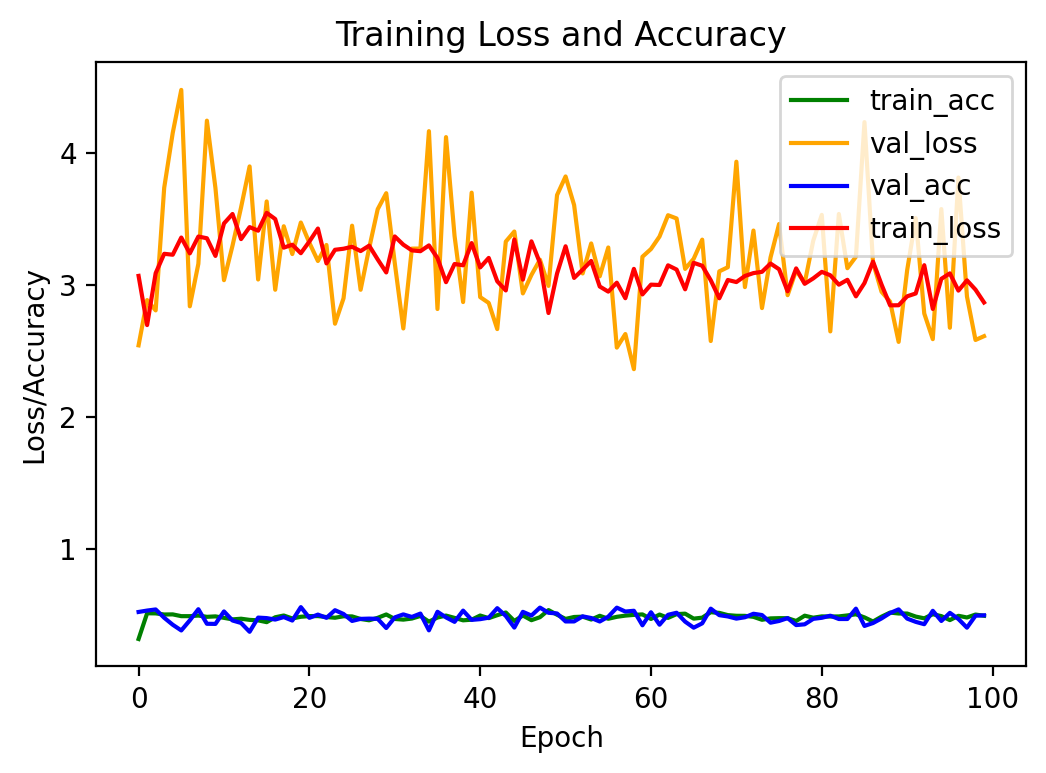

In [ ]:
learning_rate_model=modelBuilder(kernel_initializer=tf.keras.initializers.GlorotNormal, activation=tf.keras.activations.tanh,
                                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.1))
plotMetricsDependency(train_X,train_y,test_X,test_y,learning_rate_model)

Видим, что при увеличении скорости обучения качество значительно падает. Попробуем уменьшить скорость до 0.0001

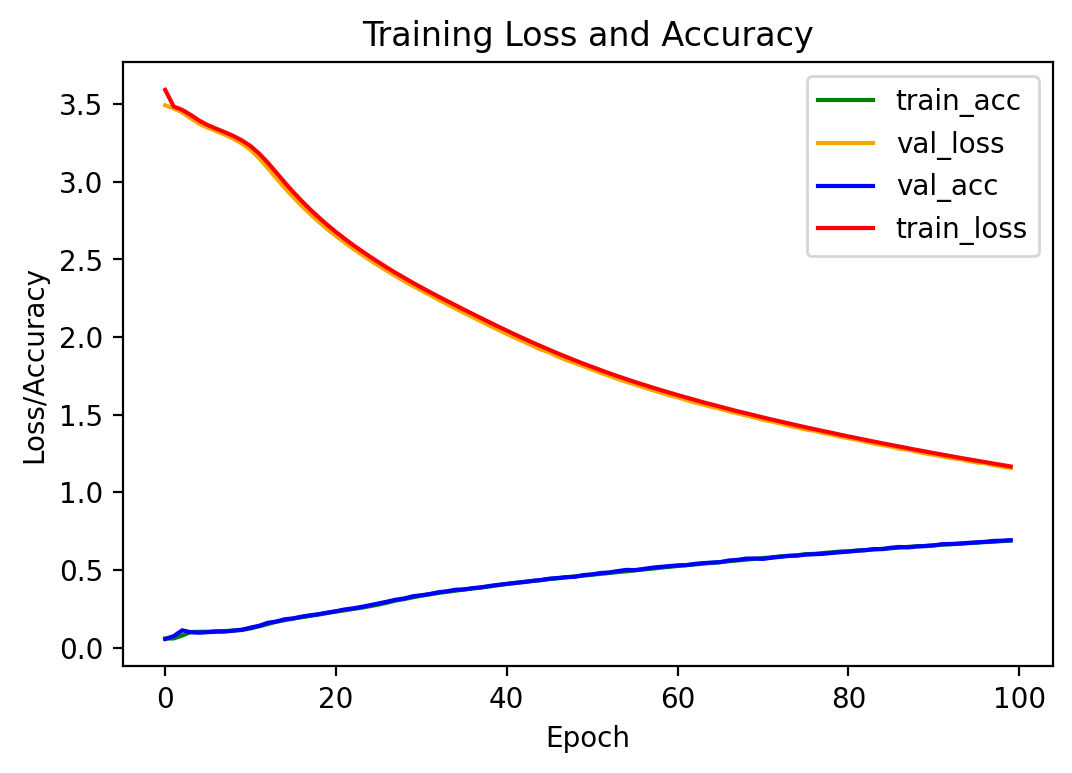

In [ ]:
learning_rate_model=modelBuilder(kernel_initializer=tf.keras.initializers.GlorotNormal, activation=tf.keras.activations.tanh,
                                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001))
plotMetricsDependency(train_X,train_y,test_X,test_y,learning_rate_model)

Видим, что значение скорости обучения 0.001 является найлучшим.Т.о пока что найлучшей является модель 
new_model=modelBuilder(kernel_initializer=tf.keras.initializers.GlorotNormal, activation=tf.keras.activations.tanh), остальные параметры заданы в модели по умолчанию

Попробуем использовать другие функции активации. Сейчас модель использует обычную гиперболический тангенс. Попробуем функции ReLU и ELU, при этом изменив способ инициализации весов на метод Хе

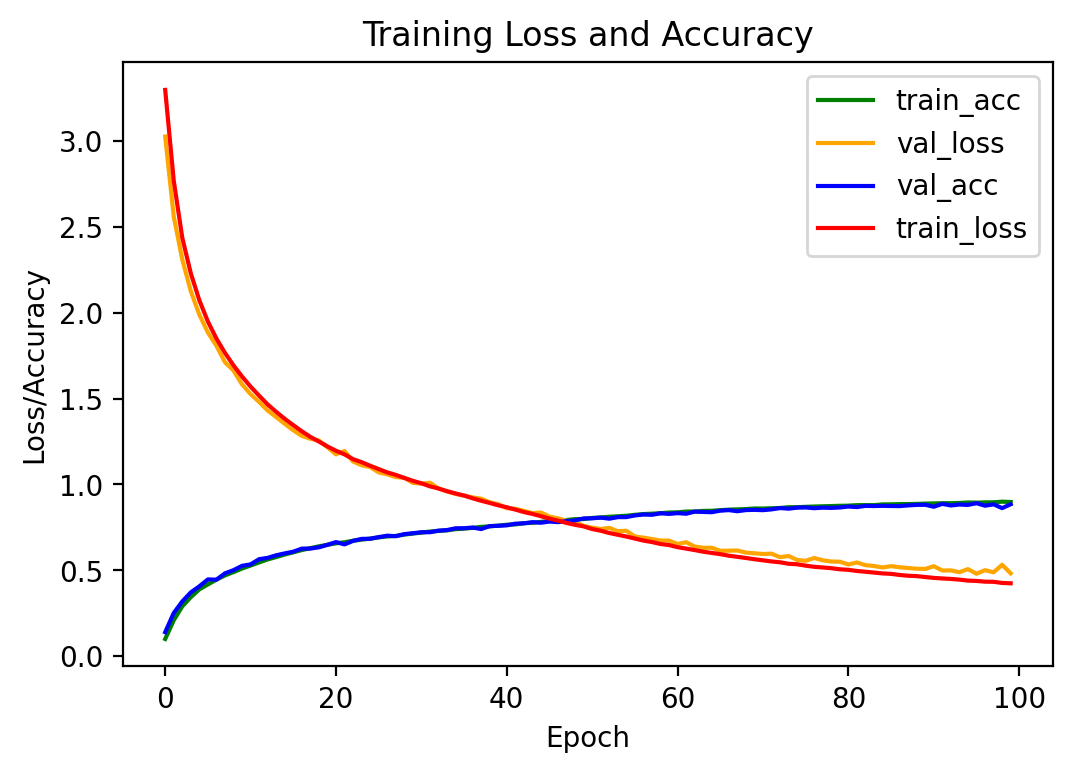

In [ ]:
model_with_ReLU = modelBuilder(kernel_initializer=tf.keras.initializers.HeNormal, activation=tf.keras.activations.relu)
plotMetricsDependency(train_X,train_y,test_X,test_y,model_with_ReLU)


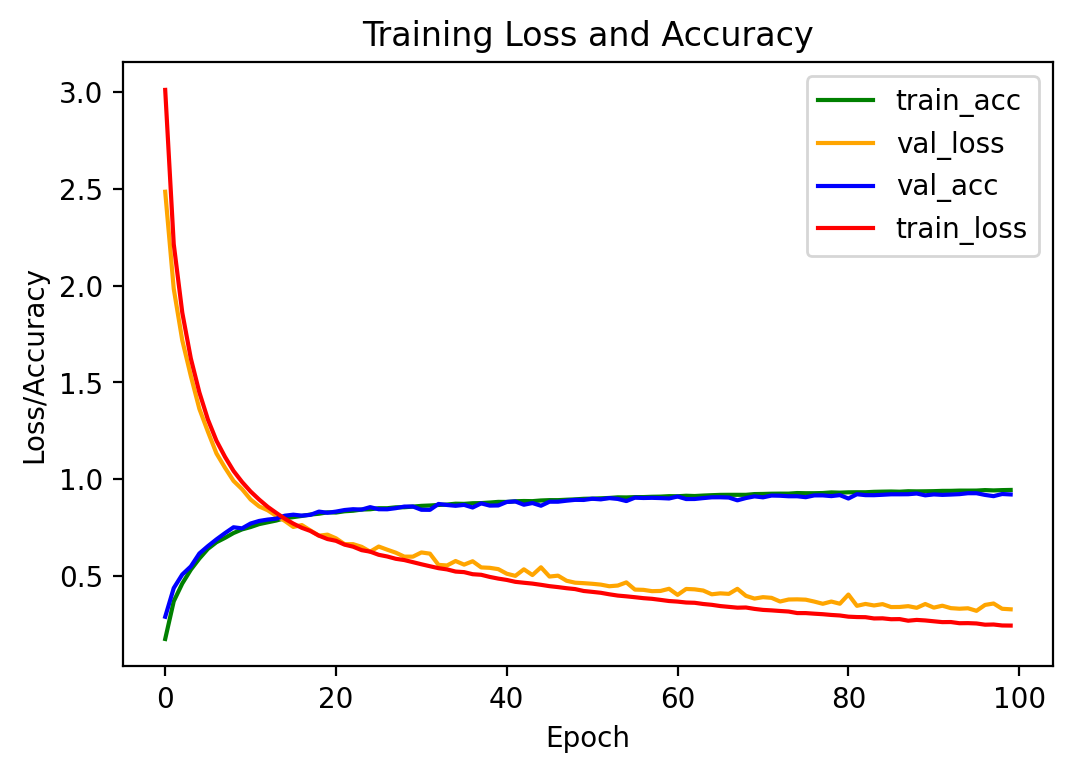

In [ ]:
model_with_ELU = modelBuilder(kernel_initializer=tf.keras.initializers.HeNormal, activation=tf.keras.activations.elu)
plotMetricsDependency(train_X,train_y,test_X,test_y,model_with_ELU)

Видим, что последняя модель на данный момент самая лучшая. Итого имеем:
model_with_ELU = modelBuilder(kernel_initializer=tf.keras.initializers.HeNormal, activation=tf.keras.activations.elu)

Попробуем использовать другой оптимизатор с такой же скоростью обучения. Воспользуемся оптимизатором AdaDelta, AdaGrad

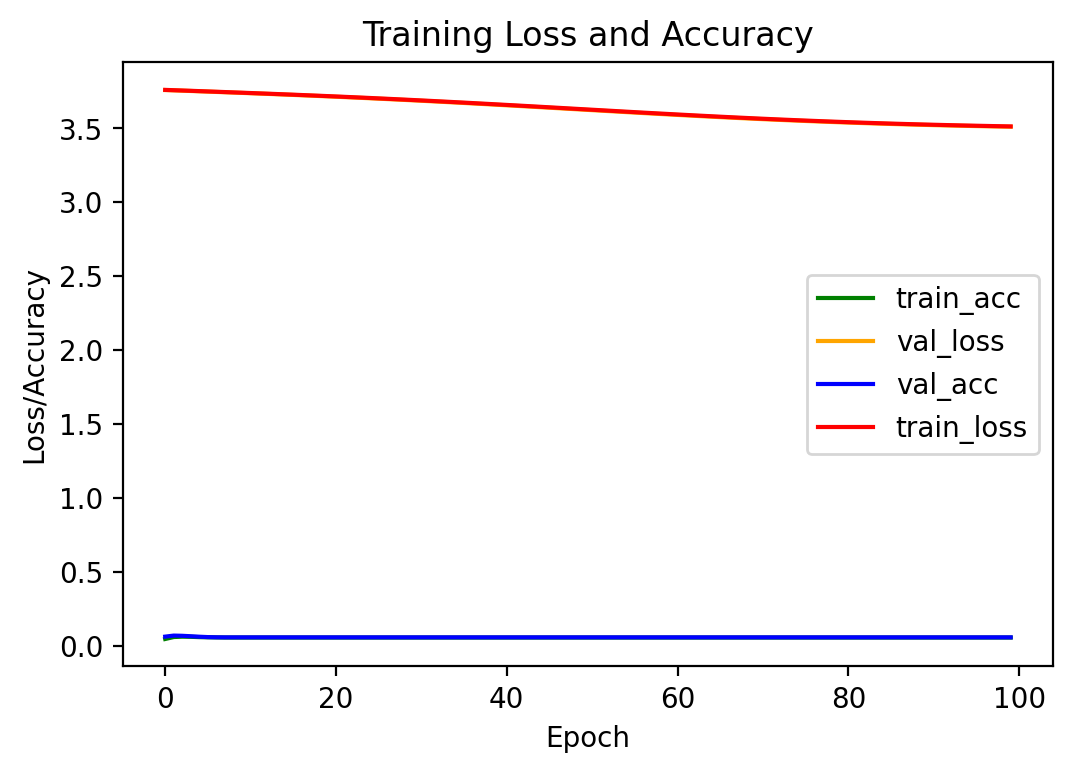

In [ ]:
model_with_AdaDelta=modelBuilder(kernel_initializer=tf.keras.initializers.HeNormal, activation=tf.keras.activations.elu,
                                 optimizer=tf.keras.optimizers.Adadelta(learning_rate=0.001))
plotMetricsDependency(train_X,train_y,test_X,test_y,model_with_AdaDelta)

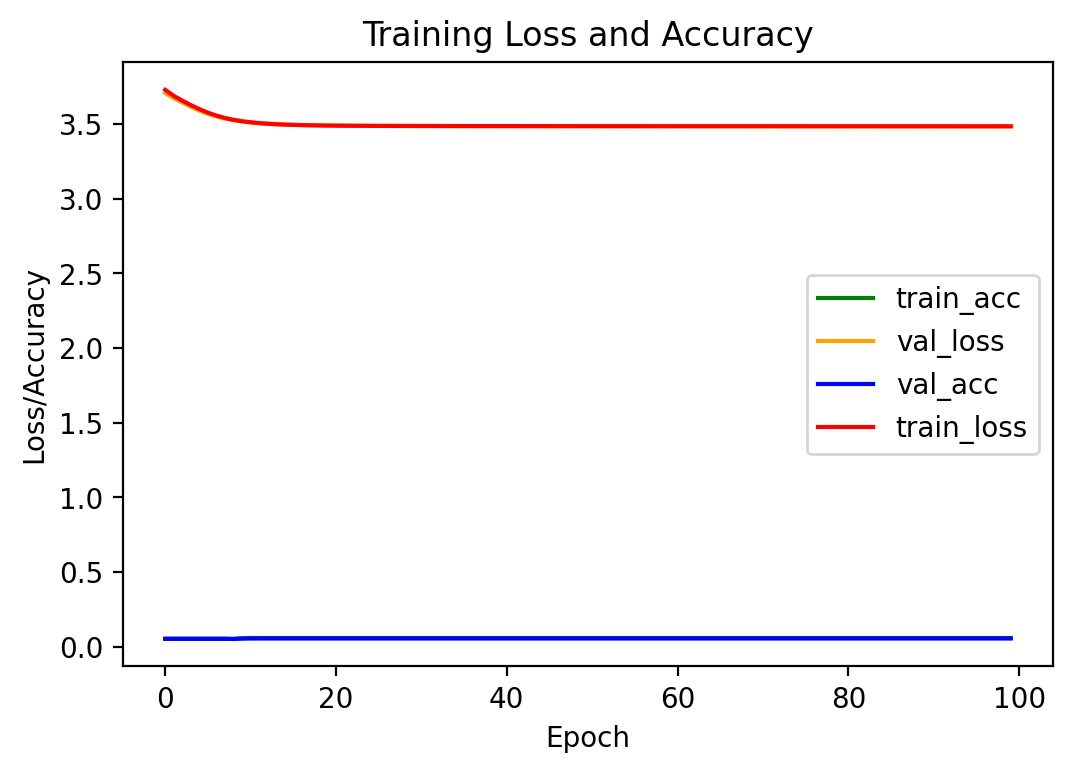

In [ ]:
model_with_AdaGrad=modelBuilder(kernel_initializer=tf.keras.initializers.HeNormal, activation=tf.keras.activations.elu,
                                 optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.001))
plotMetricsDependency(train_X,train_y,test_X,test_y,model_with_AdaGrad)

Таким образом наш текущий оптимизатор является найлучшим(Adam(lr=0.001).Добавим нормализацию к нашей найлучшей модели


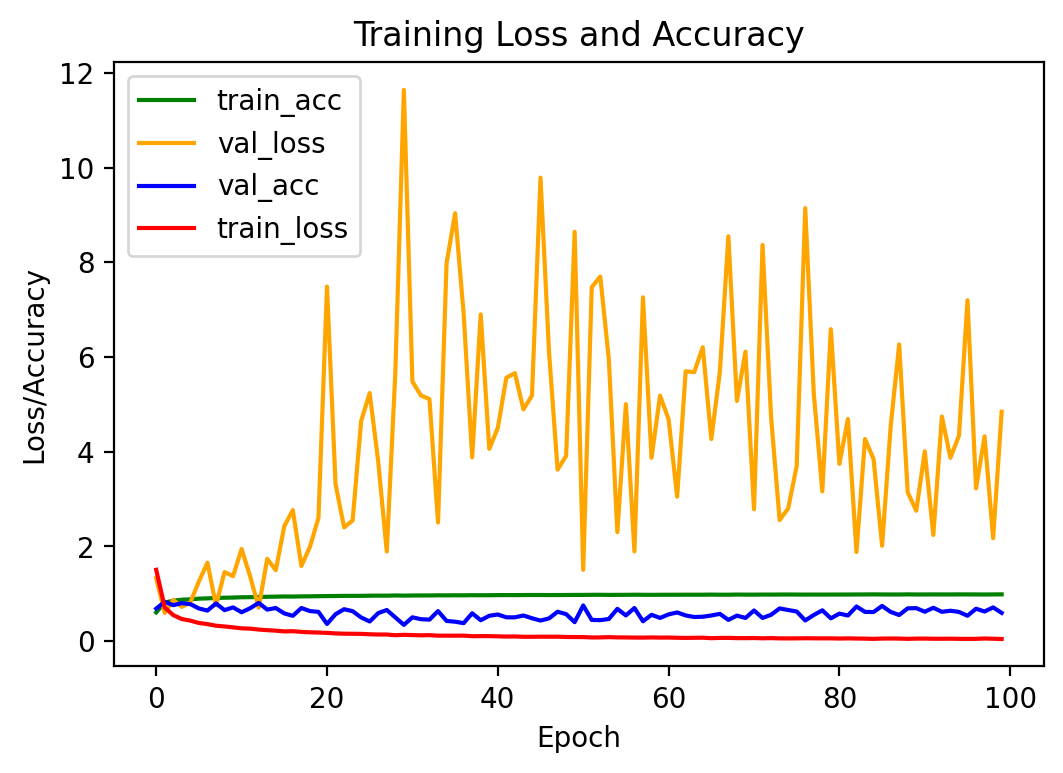

In [ ]:
model_with_ELU_Normaliz = modelBuilder(kernel_initializer=tf.keras.initializers.HeNormal, activation=tf.keras.activations.elu,
                              isBatchNorm=True)
plotMetricsDependency(train_X,train_y,test_X,test_y,model_with_ELU_Normaliz)

Нормализация явно ухудшила качество модели, потому ее мы использывать не будем. Попробуем добавить к модели дропаут

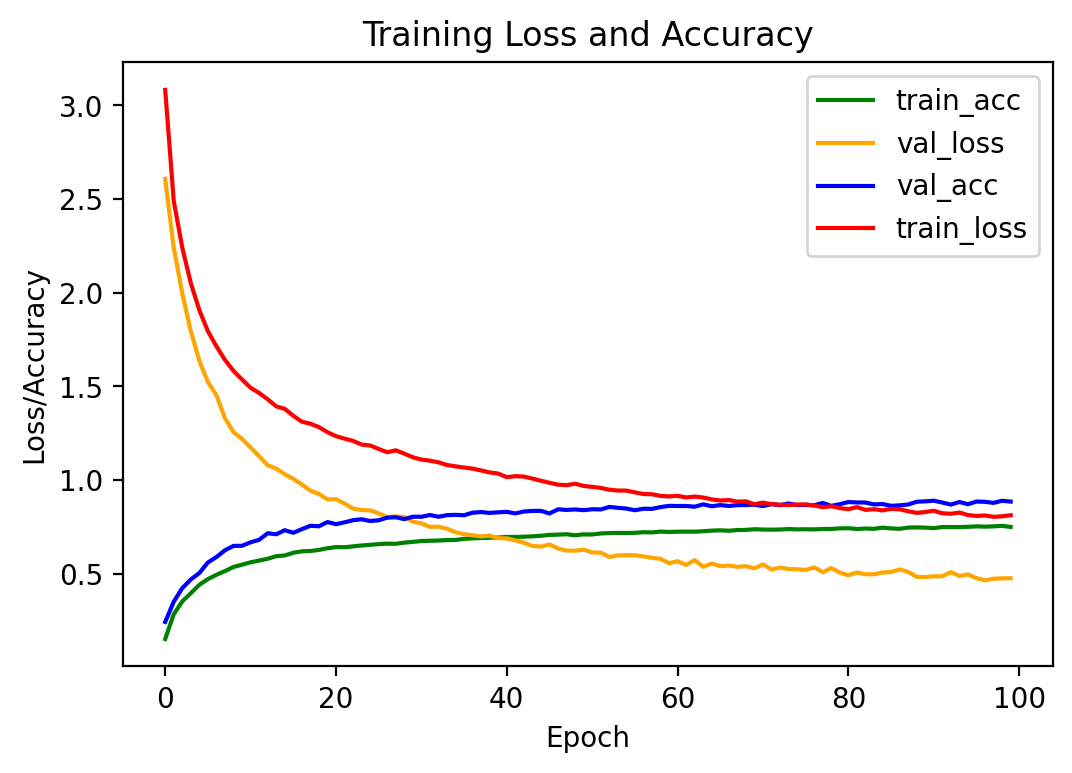

In [ ]:
model_with_ELU_Dropout = modelBuilder(kernel_initializer=tf.keras.initializers.HeNormal, activation=tf.keras.activations.elu,
                              isDropOut = True)
plotMetricsDependency(train_X,train_y,test_X,test_y,model_with_ELU_Dropout)

С использованием дропаута мы получили более переобученую модель. Попробуем увеличить вероятность до 0.5(сейчас 0.2)

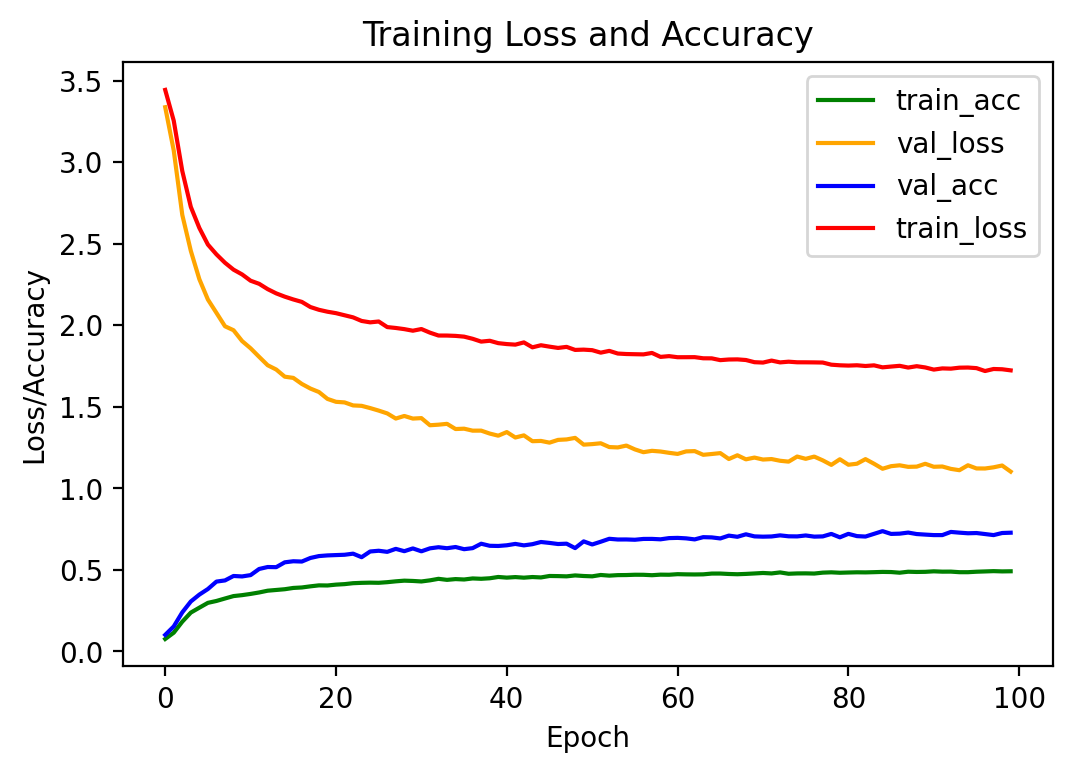

In [ ]:
model_with_ELU_Dropout = modelBuilder(kernel_initializer=tf.keras.initializers.HeNormal, activation=tf.keras.activations.elu,
                              isDropOut = True,rate=0.5)
plotMetricsDependency(train_X,train_y,test_X,test_y,model_with_ELU_Dropout)

Теперь попробуем уменьшить вероятность до 0.1

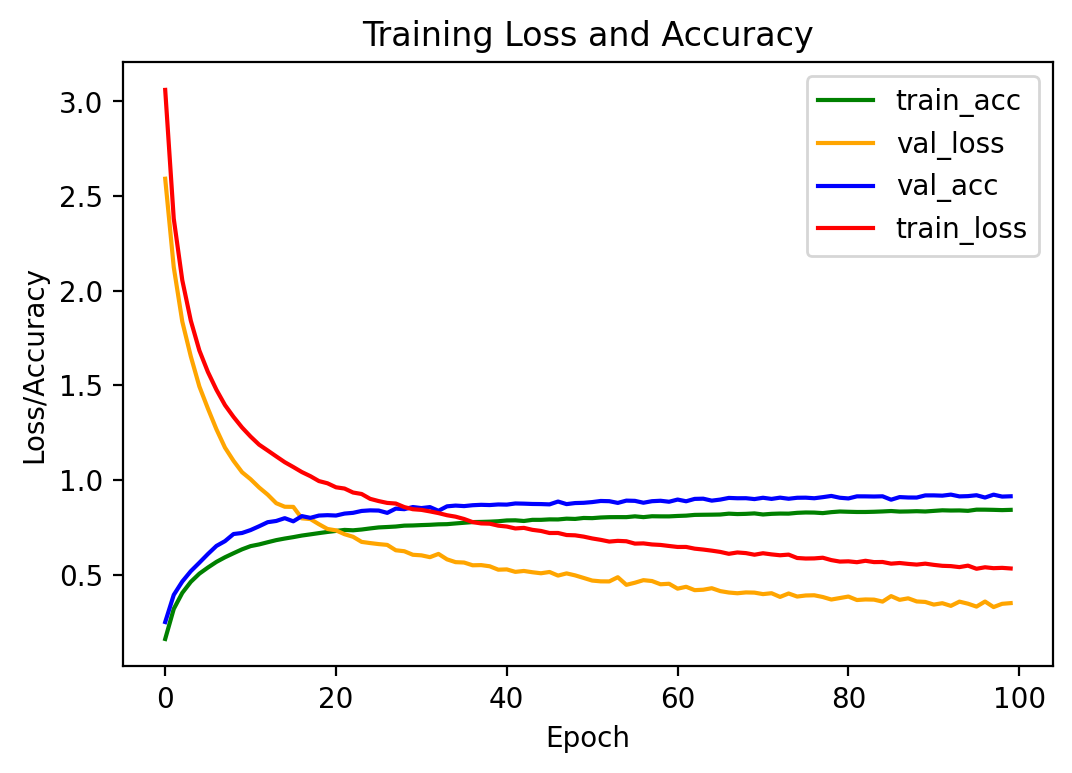

In [ ]:
model_with_ELU_Dropout = modelBuilder(kernel_initializer=tf.keras.initializers.HeNormal, activation=tf.keras.activations.elu,
                              isDropOut = True,rate=0.1)
plotMetricsDependency(train_X,train_y,test_X,test_y,model_with_ELU_Dropout)

Все равно имеем переобученную модель, потому отказываемся от нормализации. Попробуем использовать ранюю остановку обучения

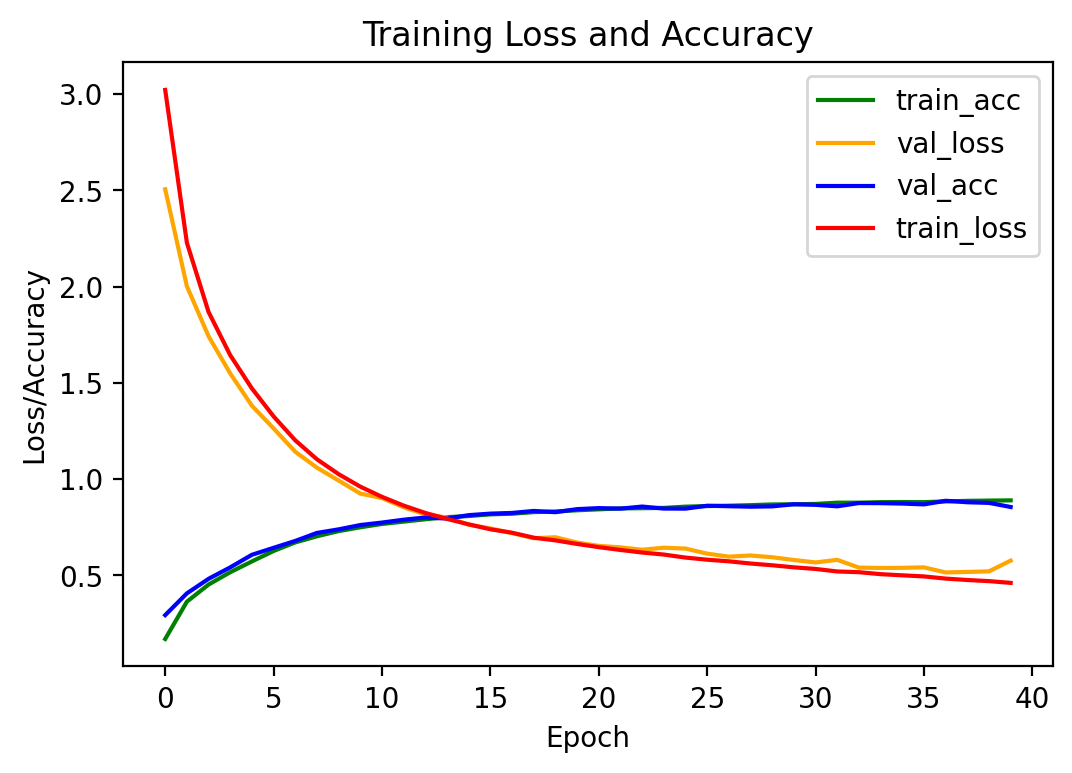

In [ ]:
model_with_ELU = modelBuilder(kernel_initializer=tf.keras.initializers.HeNormal, activation=tf.keras.activations.elu)
plotMetricsDependency(train_X,train_y,test_X,test_y,model_with_ELU,callback=tf.keras.callbacks.EarlyStopping(patience=3,monitor='val_loss'))

Видим, что ранняя остановка улучшила качество модели. Далее попробуем добавить к модели регуляризацию по первой норме

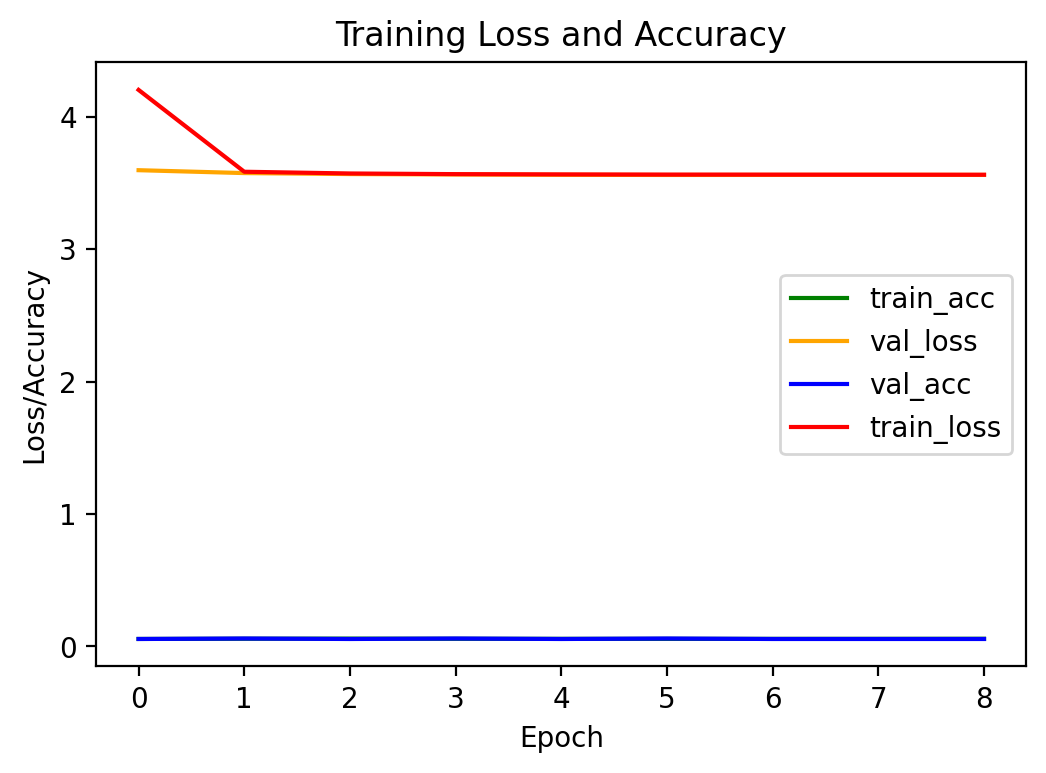

In [ ]:
model_with_ELU_L1 = modelBuilder(kernel_initializer=tf.keras.initializers.HeNormal, 
                                 activation=tf.keras.activations.elu, kernel_regularizer=tf.keras.regularizers.l1(0.01))
plotMetricsDependency(train_X,train_y,test_X,test_y,model_with_ELU_L1,callback=tf.keras.callbacks.EarlyStopping(patience=3,monitor='val_loss'))

Пробуем вторую норму

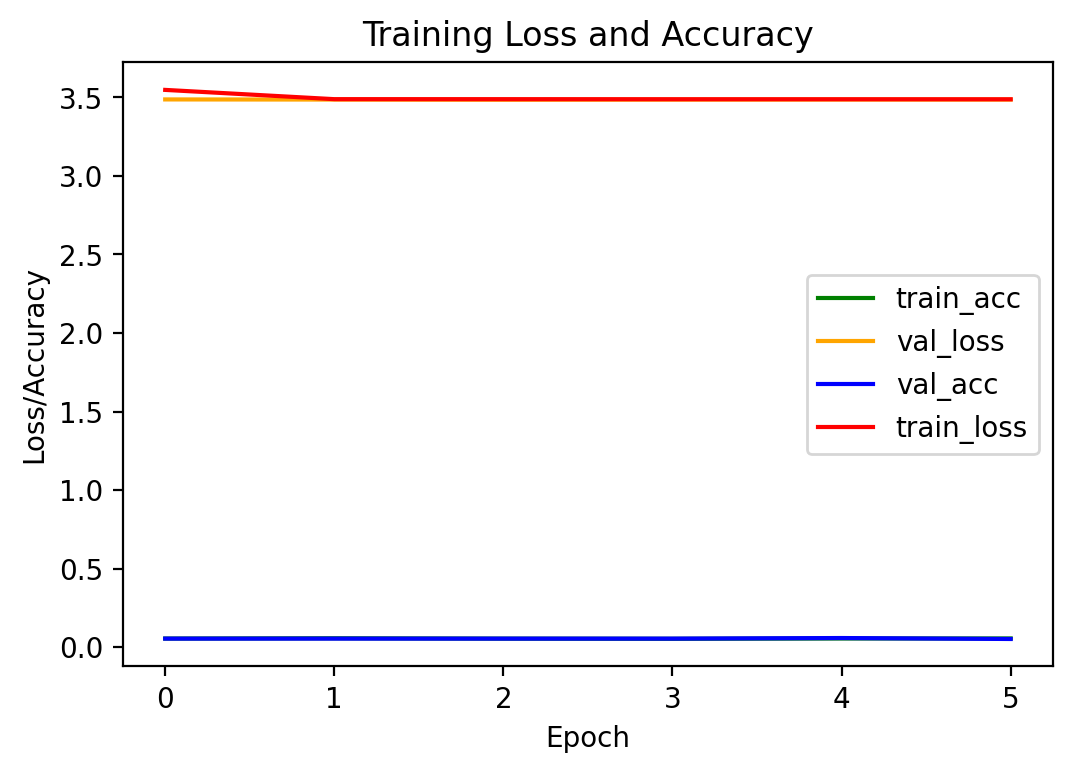

In [ ]:
model_with_ELU_L2 = modelBuilder(kernel_initializer=tf.keras.initializers.HeNormal, 
                                 activation=tf.keras.activations.elu, kernel_regularizer=tf.keras.regularizers.l2(0.01))
plotMetricsDependency(train_X,train_y,test_X,test_y,model_with_ELU_L2,callback=tf.keras.callbacks.EarlyStopping(patience=3,monitor='val_loss'))

Итого имеем такую финальную модель:

- оптимизатор Адам(0.001)
- функция активации ELU
- Инициализация Хе(нормальная)
- ранняя остановка

Попробуем сделать прогноз на основании этой модели

In [ ]:
main_model=modelBuilder(kernel_initializer=tf.keras.initializers.HeNormal, activation=tf.keras.activations.elu)
main_model.fit(train_X,train_y,epochs=100,batch_size=50,
               callbacks=tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,save_weights_only=True,verbose=0),
               verbose=0)



In [ ]:
train_loss, train_acc = main_model.evaluate(train_X, train_y, verbose=0)
test_loss, test_acc = main_model.evaluate(test_X, test_y, verbose=0)


print(f"TRAIN loss, acc = {train_loss}, {train_acc}\nTEST loss, acc = {test_loss}, {test_acc}")



TRAIN loss, acc = 0.25724613666534424, 0.9379921555519104
TEST loss, acc = 0.3544858396053314, 0.9093343615531921


In [ ]:
y_pred=main_model.predict(test_X)
lower_value=0.5
y_pred[y_pred<lower_value]=0
print(y_pred[1])
print(test_y[1])

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.99999976 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
